In [34]:
import settings
import settings_update
from helpers import misc_helpers

RUN_SIZE = 'full'

print('loading train/test data')
settings.RUN_SIZE = RUN_SIZE
settings_update.update_run_size_setup()
X_train, y_train, X_val, y_val, X_test, y_test, X, y, scaler_y = misc_helpers.get_data(
    filepath=settings.DATA_FILEPATH,
    train_years=settings.TRAIN_YEARS,
    val_years=settings.VAL_YEARS,
    test_years=settings.TEST_YEARS,
    n_points_per_group=settings.N_POINTS_PER_GROUP,
    do_standardize_data=True,
)

y_train, y_val, y_test, y = map(scaler_y.inverse_transform, [y_train, y_val, y_test, y])
y_train, y_val, y_test, y = misc_helpers.make_arrs_1d(y_train, y_val, y_test, y)
print('done')

loading train/test data


C:\Users\Mischa\Desktop\Uni\Master\MA\code\my_code\helpers\misc_helpers.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr.drop(columns=ts_cols, inplace=True)  # todo: works bc no ts cols present?
C:\Users\Mischa\Desktop\Uni\Master\MA\code\my_code\helpers\misc_helpers.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr.drop(columns=ts_cols, inplace=True)  # todo: works bc no ts cols present?
C:\Users\Mischa\Desktop\Uni\Master\MA\code\my_code\helpers\misc_helpers.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

done


In [36]:
from helpers.io_helper import IO_Helper
from helpers.arr_helpers import get_method_to_arrs_gen

ARRAYS_FOLDER = 'arrays'
MODELS_FOLDER = 'models'

METHODS_WHITELIST = set([
    'qhgbr',
    'qr',
    'gp',
    'mvnn',
    'cp_hgbr',
    'cp_linreg',
    'cp_nn',
    'la_nn',
])
UQ_METHOD_TO_ARR_NAMES_DICT = {
    'qhgbr': [
        'native_qhgbr_y_pred_n210432_it0.npy',
        'native_qhgbr_y_quantiles_n210432_it0.npy',
        'native_qhgbr_y_std_n210432_it0.npy',
    ],
    'qr': [
        'native_quantile_regression_nn_y_pred_n210432_it300_nh2_hs50.npy',
        'native_quantile_regression_nn_y_quantiles_n210432_it300_nh2_hs50.npy',
        'native_quantile_regression_nn_y_std_n210432_it300_nh2_hs50.npy',
    ],
    'gp': [
        'native_gpytorch_y_pred_n210432_it200_new.npy',
        'native_gpytorch_y_quantiles_n210432_it200_new.npy',
        'native_gpytorch_y_std_n210432_it200_new.npy',
    ],
    'mvnn': [
        'native_mvnn_y_pred_n210432_it100_nh2_hs50.npy',
        'native_mvnn_y_quantiles_n210432_it100_nh2_hs50.npy',
        'native_mvnn_y_std_n210432_it100_nh2_hs50.npy',
    ],
    'cp_hgbr': [
        'posthoc_conformal_prediction_base_model_hgbr_y_pred_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_hgbr_y_quantiles_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_hgbr_y_std_n210432_it5.npy',
    ],
    'cp_linreg': [
        'posthoc_conformal_prediction_base_model_linreg_y_pred_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_linreg_y_quantiles_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_linreg_y_std_n210432_it5.npy',
    ],
    'cp_nn': [
        'posthoc_conformal_prediction_base_model_nn_y_pred_n210432_it5_cp2.npy',
        'posthoc_conformal_prediction_base_model_nn_y_quantiles_n210432_it5_cp2.npy',
        'posthoc_conformal_prediction_base_model_nn_y_std_n210432_it5_cp2.npy',
    ],
    'la_nn': [
        'posthoc_laplace_approximation_base_model_nn_y_pred_n210432_it1000_la2.npy',
        'posthoc_laplace_approximation_base_model_nn_y_quantiles_n210432_it1000_la2.npy',
        'posthoc_laplace_approximation_base_model_nn_y_std_n210432_it1000_la2.npy',
    ],
}


print('loading predictions')
io_helper = IO_Helper(arrays_folder=ARRAYS_FOLDER, models_folder=MODELS_FOLDER)

n_test_samples = y_test.shape[0]

uq_method_to_arrs_gen = get_method_to_arrs_gen(
    methods_whitelist=METHODS_WHITELIST,
    method_to_arr_names_dict=UQ_METHOD_TO_ARR_NAMES_DICT,
    io_helper=io_helper,
)
uq_method_to_arrs_dict = dict(uq_method_to_arrs_gen)
print('done')

loading predictions
done


In [44]:
# compute calibrations

print('computing calibrations')

y_test_rep = np.vstack([y_test] * len(settings.QUANTILES))
y_test_rep = y_test_rep.transpose()

method_calibrations = {}
for method, arrs in uq_method_to_arrs_dict.items():
    y_pred, y_quantiles, y_std = arrs
    y_pred_test, y_quantiles_test, y_std_test = [arr[-n_test_samples:] for arr in arrs]

    calibration_arr = (y_test_rep <= y_quantiles_test)
    calibration_vals = calibration_arr.mean(axis=0)
    method_calibrations[method] = calibration_vals
print('done')

computing calibrations
done


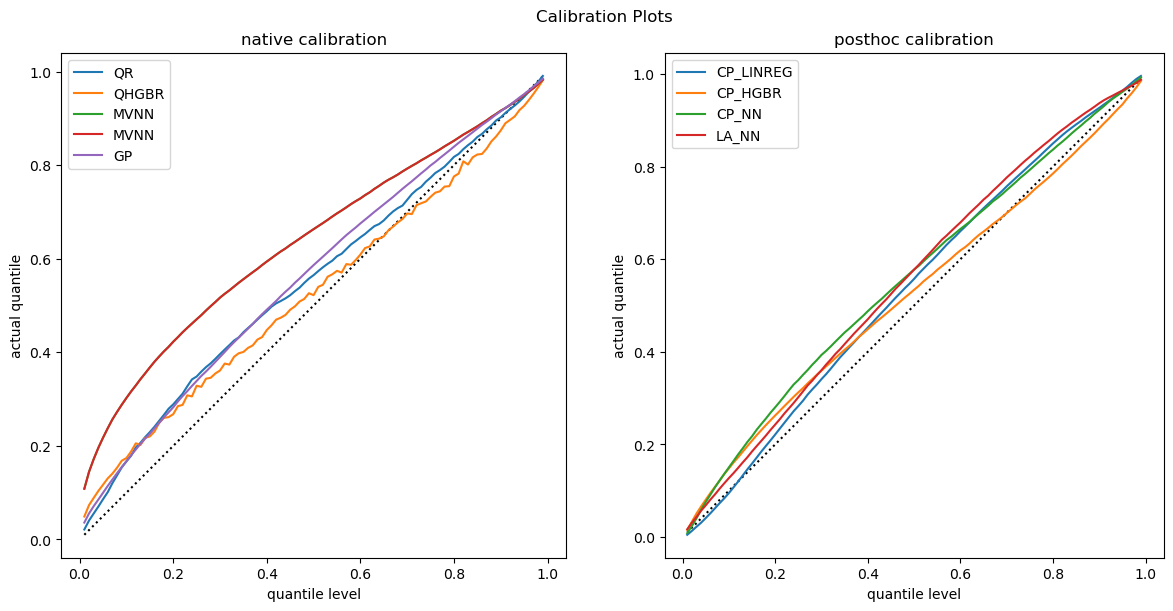

In [50]:
import numpy as np

DPI = 100
FILEPATH = 'comparison_storage/plots/calibration_plot.png'


METHOD_TYPE_DICT = {
    'native': ['qr', 'qhgbr', 'mvnn', 'mvnn', 'gp'],
    'posthoc': ['cp_linreg', 'cp_hgbr', 'cp_nn', 'la_nn']
}
# METHOD_TO_MODEL_CATEGORIES_DICT = {
#     'native': {
#         'qr': 'Baseline',
#         'qhgbr': 'Tree',
#         'mvnn': 'NN',
#         'mvnn': 'NN',
#         'gp': 'GP',
#     },
#     'posthoc': {
#         'cp_linreg': 'Baseline',
#         'cp_hgbr': 'Tree',
#         'cp_nn': 'NN',
#         'la_nn': 'NN',
#     }
# }
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
# categories = ['Baseline', 'Tree', 'NN', 'GP']
# CATEGORY_TO_COLOR_DICT = dict(zip(categories, colors))

x_plot = settings.QUANTILES
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), layout='constrained', dpi=DPI)
fig.suptitle('Calibration Plots')
for ax, (method_type, methods) in zip(axs, METHOD_TYPE_DICT.items()):
    ax.set_aspect('equal')
    ax.plot(x_plot, x_plot, linestyle='dotted', color='black')
    ax.set_title(f'{method_type} calibration')
    ax.set_xlabel('quantile level')
    ax.set_ylabel('actual quantile')

    for method, color in zip(methods, COLORS):
        calibrations = method_calibrations[method]
        ax.plot(x_plot, calibrations, label=method.upper())
    ax.legend()

# legend_elements = [Line2D([0], [0], marker='o', markerfacecolor=color, color='w', label=method_type, markersize=np.sqrt(SCATTER_SIZE))
#                    for method_type, color in zip(TYPE_TO_METHOD_PAIRS.keys(), COLORS)]

# fig.legend(handles=legend_elements, bbox_to_anchor=(7/8, 3/4), loc='center')

if FILEPATH is not None:
    plt.savefig(FILEPATH)

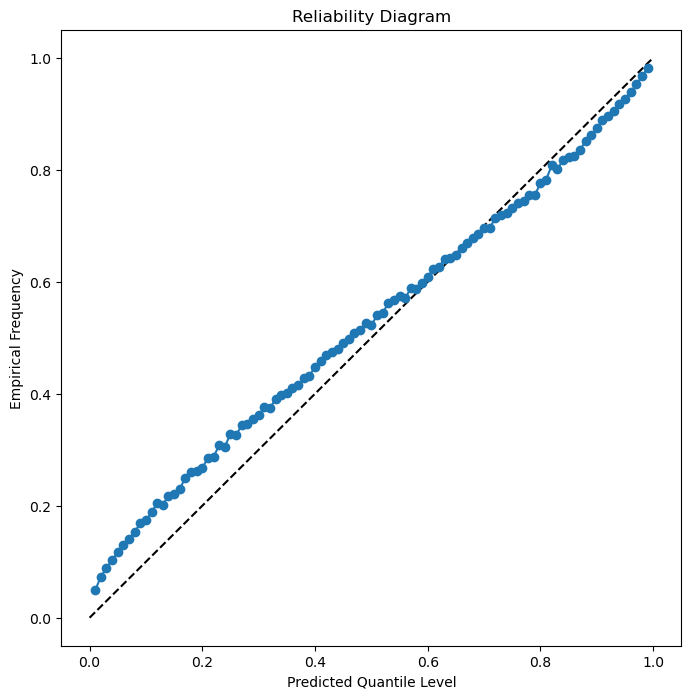

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def f():
    y = y_test
    y_quantiles = y_quantiles_test
    
    # Assuming quantile levels are [0.1, 0.2, ..., 0.9]
    quantile_levels = np.linspace(0.01, 0.99, y_quantiles.shape[1])
    
    # Calculate empirical frequencies
    empirical_freqs = []
    for i in range(len(quantile_levels)):
        empirical_freqs.append(np.mean(y <= y_quantiles[:, i]))
    
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.plot(quantile_levels, empirical_freqs, 'o-')
    plt.xlabel('Predicted Quantile Level')
    plt.ylabel('Empirical Frequency')
    plt.title('Reliability Diagram')

f()

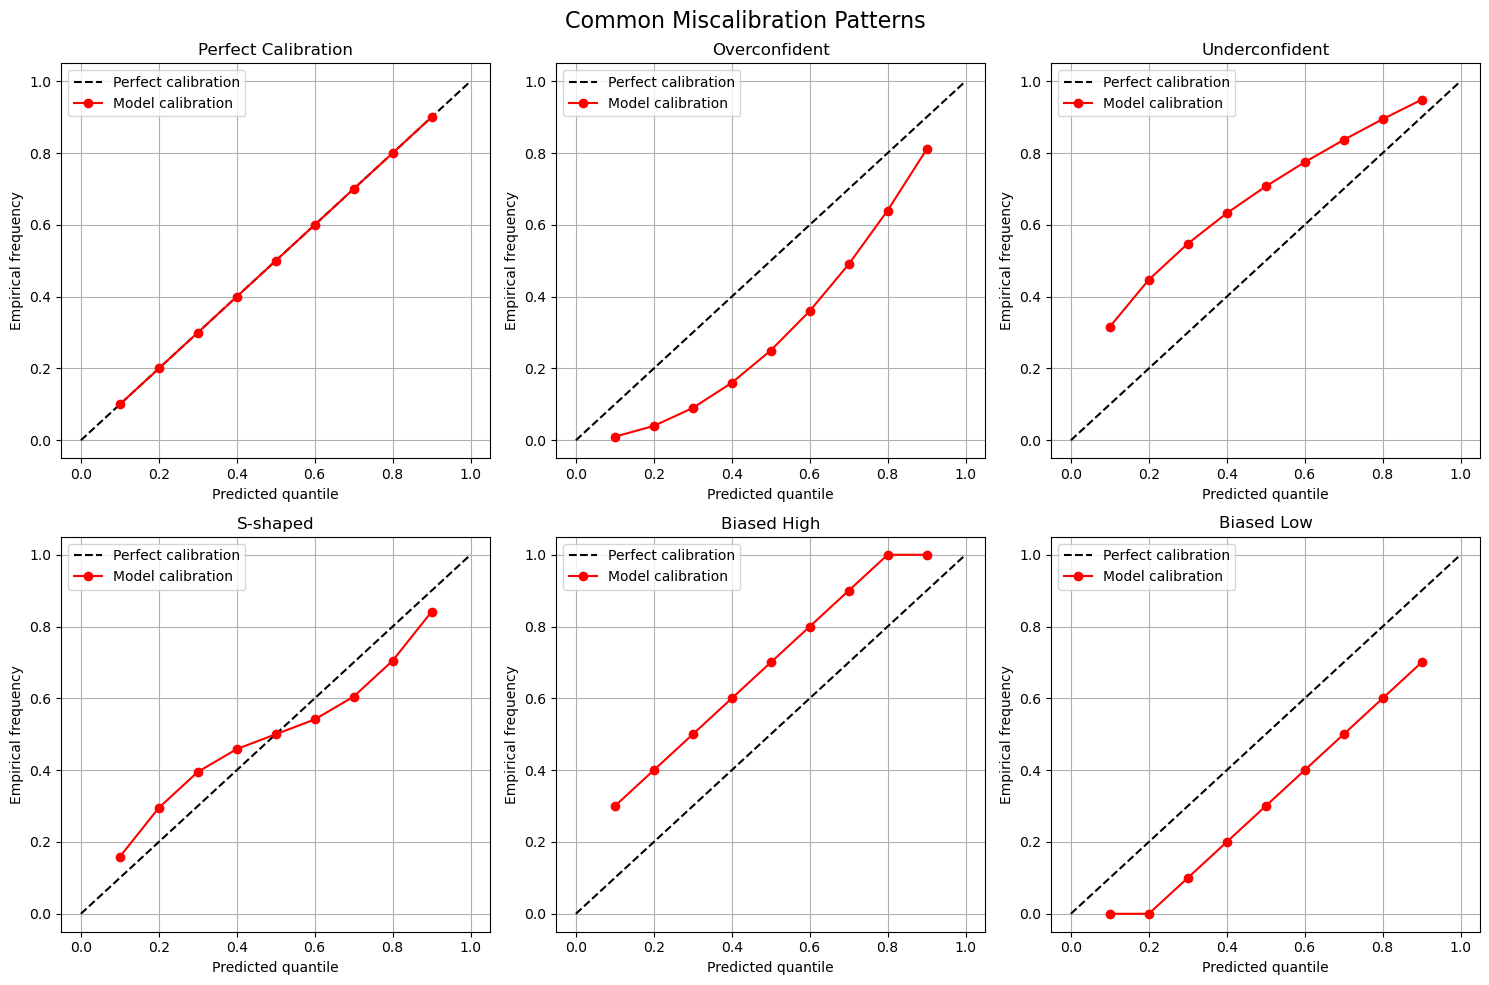

In [31]:
# code by claude

import numpy as np
import matplotlib.pyplot as plt

def plot_calibration_patterns():
    # Create quantile levels
    quantile_levels = np.linspace(0.1, 0.9, 9)
    
    # Perfect calibration
    perfect = quantile_levels
    
    # Different miscalibration patterns
    overconfident = quantile_levels ** 2  # Points below diagonal
    underconfident = np.sqrt(quantile_levels)  # Points above diagonal
    s_shaped = quantile_levels + 0.1 * np.sin(2 * np.pi * quantile_levels)  # S-curve
    biased_high = np.minimum(quantile_levels + 0.2, 1)  # Shifted up
    biased_low = np.maximum(quantile_levels - 0.2, 0)  # Shifted down
    
    # Create subplot for each pattern
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Common Miscalibration Patterns', fontsize=16)
    
    # Plot each pattern
    patterns = {
        'Perfect Calibration': perfect,
        'Overconfident': overconfident,
        'Underconfident': underconfident,
        'S-shaped': s_shaped,
        'Biased High': biased_high,
        'Biased Low': biased_low
    }
    
    for (title, pattern), ax in zip(patterns.items(), axes.flat):
        ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
        ax.plot(quantile_levels, pattern, 'o-r', label='Model calibration')
        ax.set_xlabel('Predicted quantile')
        ax.set_ylabel('Empirical frequency')
        ax.set_title(title)
        ax.grid(True)
        ax.legend()
        
    plt.tight_layout()
    plt.show()

plot_calibration_patterns()